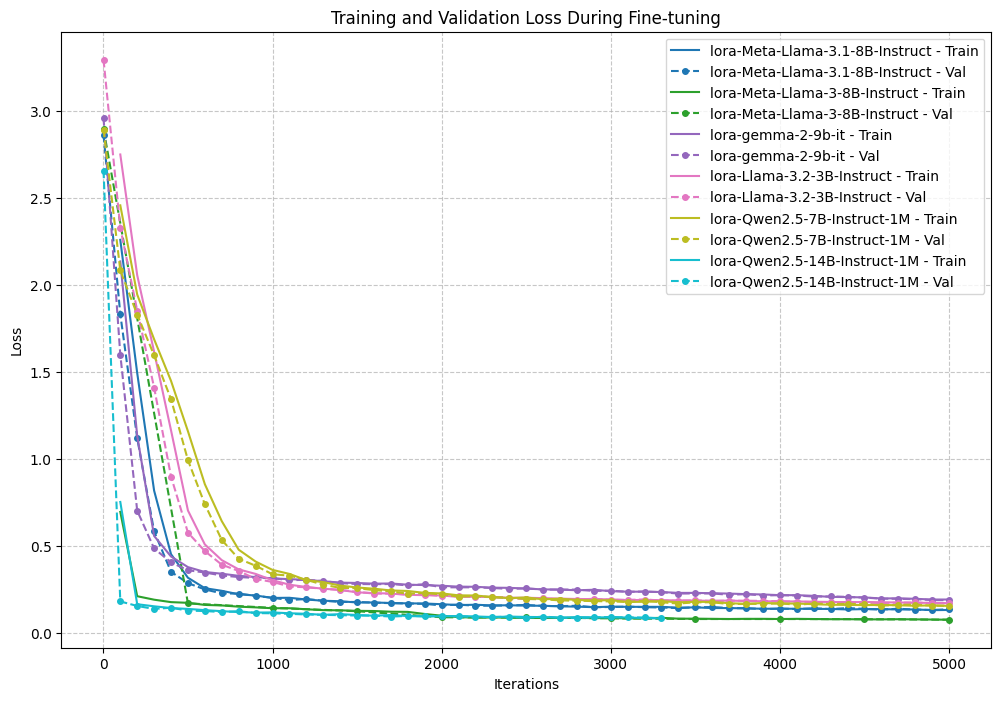

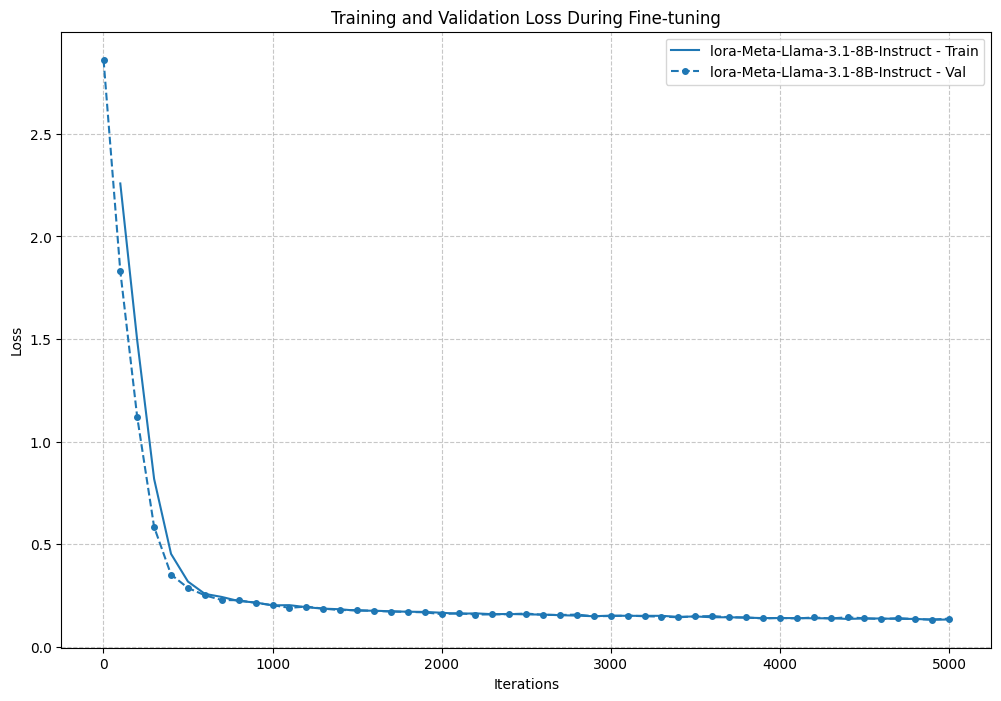

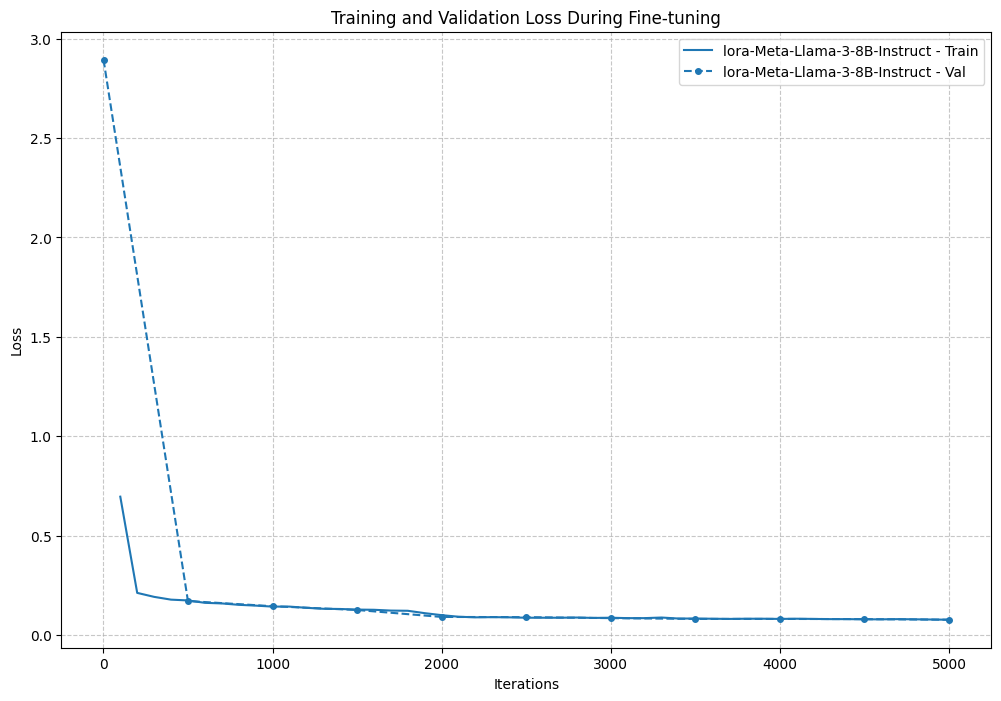

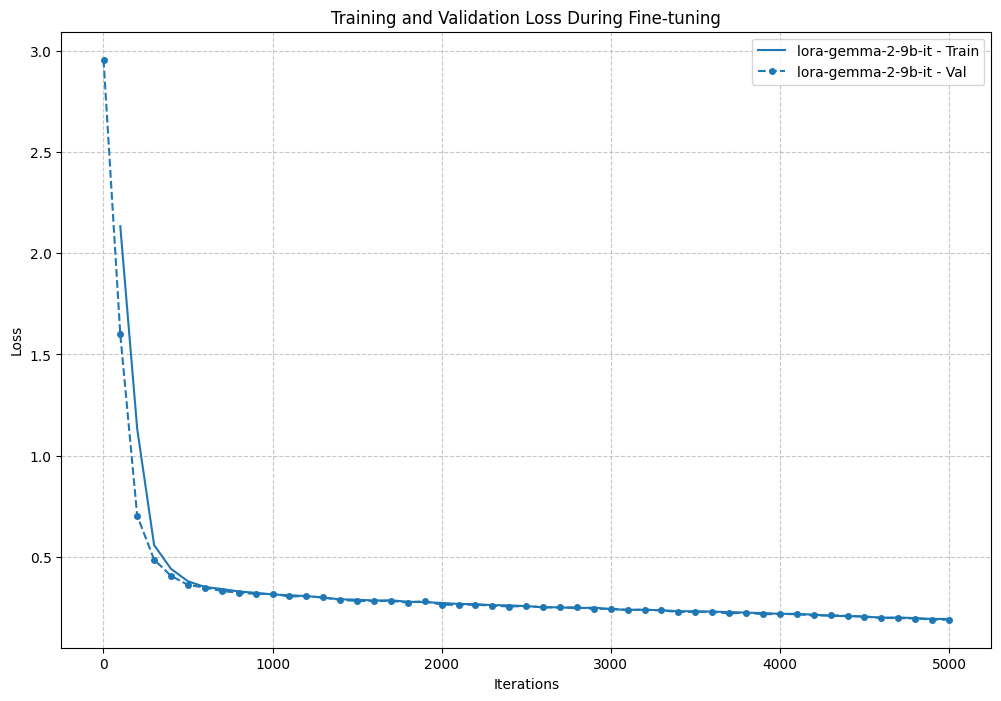

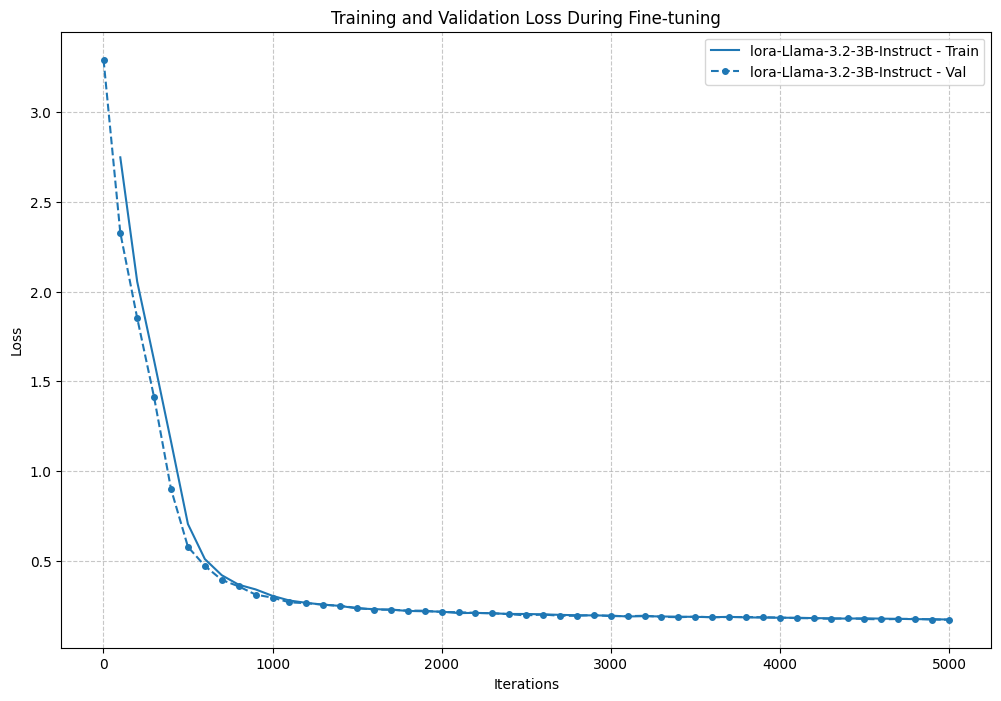

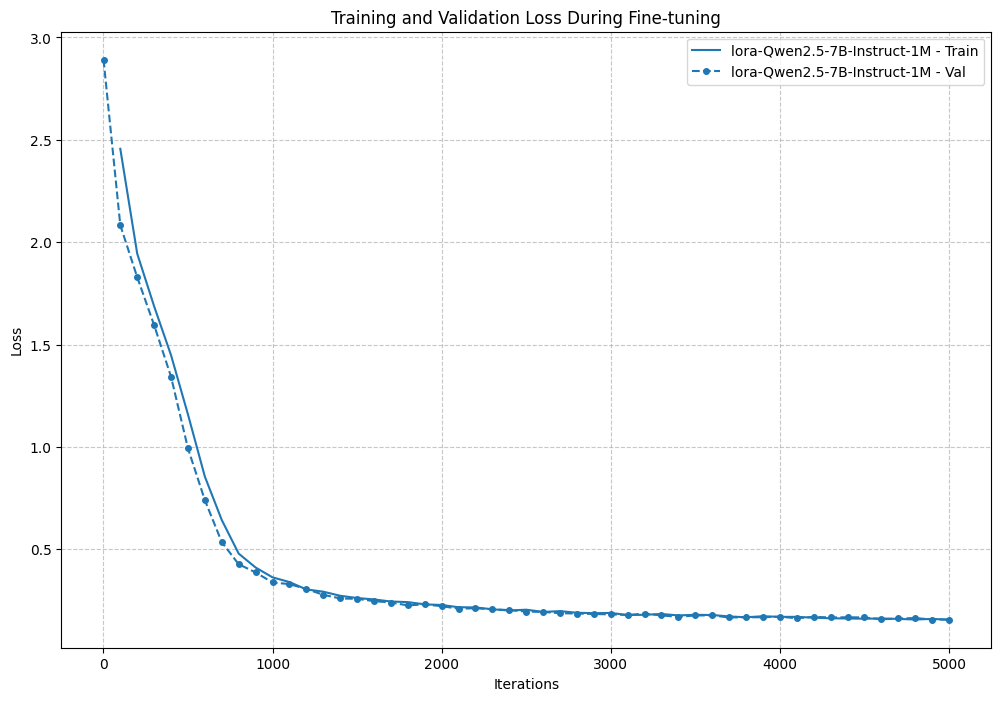

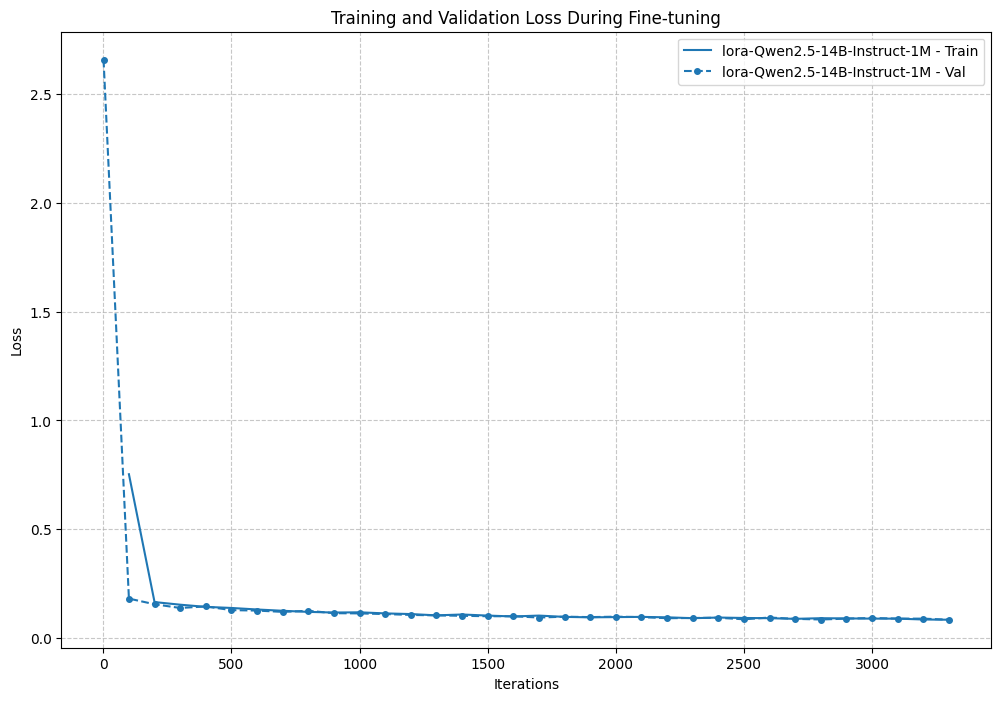

In [8]:
import re
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from pathlib import Path


def extract_metrics_from_log(log_file_path):
    """Extract training and validation loss metrics from a fine-tuning log file."""
    with open(log_file_path, 'r') as f:
        log_content = f.read()

    # Extract model name from filename
    model_name = os.path.basename(log_file_path).replace('.log', '')

    # Extract iterations, training loss, and validation loss
    train_pattern = r"Iter (\d+): Train loss ([0-9.]+),"
    val_pattern = r"Iter (\d+): Val loss ([0-9.]+),"

    train_matches = re.findall(train_pattern, log_content)
    val_matches = re.findall(val_pattern, log_content)

    train_iterations = [int(match[0]) for match in train_matches]
    train_losses = [float(match[1]) for match in train_matches]

    val_iterations = [int(match[0]) for match in val_matches]
    val_losses = [float(match[1]) for match in val_matches]

    return {
        'model_name': model_name,
        'train_iterations': train_iterations,
        'train_losses': train_losses,
        'val_iterations': val_iterations,
        'val_losses': val_losses
    }


def plot_training_metrics(log_files, save_path=None, figsize=(12, 8)):
    """Plot training and validation loss for multiple models."""
    plt.figure(figsize=figsize)

    # Create color cycle for different models
    colors = plt.cm.tab10(np.linspace(0, 1, len(log_files)))


    for log_file, color in zip(log_files, colors):
        metrics = extract_metrics_from_log(log_file)
        model_name = metrics['model_name']

        # if model_name in skip_models:
        #     continue

        # Plot training loss
        plt.plot(metrics['train_iterations'], metrics['train_losses'],
                 color=color, linestyle='-', marker='', label=f"{model_name} - Train")

        # Plot validation loss
        plt.plot(metrics['val_iterations'], metrics['val_losses'],
                 color=color, linestyle='--', marker='o', markersize=4, label=f"{model_name} - Val")

    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss During Fine-tuning')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    # # Add textbox showing final metrics
    # for log_file, color in zip(log_files, colors):
    #     metrics = extract_metrics_from_log(log_file)
    #     model_name = metrics['model_name']
    #     final_train_loss = metrics['train_losses'][-1]
    #     final_val_loss = metrics['val_losses'][-1]

    #     plt.annotate(f"{model_name}\nFinal train: {final_train_loss:.4f}\nFinal val: {final_val_loss:.4f}",
    #                  xy=(0.02, 0.02), xycoords='figure fraction',
    #                  bbox=dict(boxstyle="round,pad=0.5",
    #                            facecolor='white', alpha=0.8),
    #                  fontsize=9)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


# Example usage
logs_dir = '../logs'
log_files = glob.glob(os.path.join(logs_dir, '*.log'))

skip_models = ["lora-Meta-Llama-3-8B-Instruct-lr-5*6",
               "lora-Meta-Llama-3-8B-Instruct-lr-6",
               "postflop-llama-3.1-8B-Instruct",
               "preflop-llama-3.1-8B-Instruct",
               "lora-DeepSeek-R1-Distill-Llama-8B",
               "dora-Meta-Llama-3.1-8B-Instruct",
               "lora-Meta-Llama-3.1-8B-Instruct-lr-5",
               "lora-Llama-3.2-3B-Instruct-lr-5"
               ]

log_files = [log_file for log_file in log_files if Path(log_file).stem not in skip_models]

if log_files:
    plot_training_metrics(log_files, save_path='../visualizations/all_models.png')
else:
    print("No log files found in the logs directory.")

# You can also analyze just one model
for log_file in log_files:
    plot_training_metrics([log_file], save_path=f"../visualizations/{Path(log_file).stem}.png")

In [1]:
def plot_overfitting_analysis(log_files, save_path=None, figsize=(12, 8)):
    """Plot the difference between validation and training loss to analyze overfitting."""
    plt.figure(figsize=figsize)

    for log_file, color in zip(log_files, plt.cm.tab10(np.linspace(0, 1, len(log_files)))):
        metrics = extract_metrics_from_log(log_file)
        model_name = metrics['model_name']

        # Find common iterations between train and val
        common_iters = list(set(metrics['train_iterations']).intersection(
            set(metrics['val_iterations'])))
        common_iters.sort()

        # Get train and val losses for common iterations
        train_losses = [metrics['train_losses']
                        [metrics['train_iterations'].index(i)] for i in common_iters]
        val_losses = [metrics['val_losses']
                      [metrics['val_iterations'].index(i)] for i in common_iters]

        # Calculate difference
        loss_diff = [val - train for val,
                     train in zip(val_losses, train_losses)]

        plt.plot(common_iters, loss_diff, label=model_name, color=color)

    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.xlabel('Iterations')
    plt.ylabel('Validation Loss - Training Loss')
    plt.title(
        'Overfitting Analysis: Difference Between Validation and Training Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


# Run overfitting analysis if log files exist
if log_files:
    plot_overfitting_analysis(log_files)

NameError: name 'log_files' is not defined